# Training a ConvNet PyTorch

In this notebook, you'll learn how to use the powerful PyTorch framework to specify a conv net architecture and train it on the human action recognition dataset. 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,sampler,Dataset
import torchvision.datasets as dset
import torchvision.transforms as T
import timeit
from PIL import Image
import os
import numpy as np
import scipy.io


In [3]:
# # http://pytorch.org/
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# # !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
# # import torc
# !pip install scipy

In [ ]:
# !pip install -U -q PyDrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # PyDrive reference:
# # https://googledrive.github.io/PyDrive/docs/build/html/index.html

# # 2. Create & upload a file text file.
# uploaded = drive.CreateFile({'title': 'Sample upload.txt'})


In [7]:
#fileId = drive.CreateFile({'id': '1eGfovYSMsqTUlyXksU35FHOq1EB9LAQt'}) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
#print(fileId['title']) # folder_data.zip
#fileId.GetContentFile('data.zip')


data.zip


In [1]:
#!unzip data.zip -d ./

In [ ]:
# Helper functions

IS_CUDA = False
if torch.cuda.is_available():
    IS_CUDA = True

def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

def makeCuda():
    if IS_CUDA:
        x = x.cuda()
    return x

In [3]:
IS_CUDA

True

## What's this PyTorch business?

* When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly.
* this notebook will walk you through much of what you need to do to train models using pytorch. if you want to learn more or need further clarification on topics that aren't fully explained here, here are 2 good Pytorch tutorials. 1): http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html 2)http://pytorch.org/tutorials/beginner/pytorch_with_examples.html
* It's not necessary to have a GPU for this homework, using a GPU can make your code run faster.


## Load Datasets

In this part, we will load the action recognition dataset for the neural network. In order to load data from our custom dataset, we need to write a custom Dataloader. If you put q3_2_data.mat, /valClips,/trainClips,/testClips under the folder of ./data/ , you do not need to change anything in this part.

First, load the labels of the dataset, you should write your path of the q3_2_data.mat file.

In [4]:
label_mat=scipy.io.loadmat('./data/q3_2_data.mat')
label_train=label_mat['trLb']
print(len(label_train))
label_val=label_mat['valLb']
print(len(label_val))

7770
2230


### Dataset class

torch.utils.data.Dataset is an abstract class representing a dataset. The custom dataset should inherit Dataset and override the following methods:

    __len__ so that len(dataset) returns the size of the dataset.
    __getitem__ to support the indexing such that dataset[i] can be used to get ith sample

Let’s create a dataset class for our action recognition dataset. We will read images in __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict {'image':image,'img_path':img_path,'Label':Label}. Our datset will take an optional argument transform so that any required processing can be applied on the sample. 

In [ ]:
%matplotlib inline
class ActionDataset(Dataset):
    """Action dataset."""

    def __init__(self,  root_dir,labels=[], transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            labels(list): labels if images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels
    def __len__(self):
        return self.length*3

    def __getitem__(self, idx):
        
        folder= int(idx/3+1)
        imidx=int(idx%3+1)
        folder=format(folder,'05d')
        imgname=str(imidx)+'.jpg'
        img_path = os.path.join(self.root_dir,
                                folder,imgname)
        image = Image.open(img_path)
        if len(self.labels)!=0:
            Label=self.labels[int(idx/3)][0]-1
        if self.transform:
            image = self.transform(image)
        if len(self.labels)!=0:
            sample={'image':image,'img_path':img_path,'Label':Label}
        else:
            sample={'image':image,'img_path':img_path}
        return sample
  

In [2]:
# !pip install Pillow==4.0.0
# !pip install PIL
# !pip install image
# from PIL import Image

Iterating over the dataset by a for loop.

In [12]:
image_dataset=ActionDataset(root_dir='./data/trainClips/',\
                            labels=label_train,transform=T.ToTensor())

#iterating though the dataset
for i in range(10):
    sample=image_dataset[i]
    print(sample['image'].shape)
    print(sample['Label'])
    print(sample['img_path'])
     
   

torch.Size([3, 64, 64])
0.0
./data/trainClips/00001/1.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00001/2.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00001/3.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00002/1.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00002/2.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00002/3.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00003/1.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00003/2.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00003/3.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00004/1.jpg


We can iterate over the created dataset with a 'for' loop as before. However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. 

In [13]:
image_dataloader = DataLoader(image_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


for i,sample in enumerate(image_dataloader):
    sample['image'] = var(sample['image'])
    print(i,sample['image'].shape,sample['img_path'],sample['Label'])
    if i>20: 
        break

(0, torch.Size([4, 3, 64, 64]), ['./data/trainClips/02322/2.jpg', './data/trainClips/04419/2.jpg', './data/trainClips/00249/1.jpg', './data/trainClips/06168/1.jpg'], 
 2
 5
 0
 7
[torch.DoubleTensor of size 4]
)
(1, torch.Size([4, 3, 64, 64]), ['./data/trainClips/00338/1.jpg', './data/trainClips/06637/3.jpg', './data/trainClips/04659/1.jpg', './data/trainClips/07360/2.jpg'], 
 0
 8
 5
 9
[torch.DoubleTensor of size 4]
)
(2, torch.Size([4, 3, 64, 64]), ['./data/trainClips/06421/2.jpg', './data/trainClips/05755/2.jpg', './data/trainClips/01909/2.jpg', './data/trainClips/02401/3.jpg'], 
 7
 7
 2
 2
[torch.DoubleTensor of size 4]
)
(3, torch.Size([4, 3, 64, 64]), ['./data/trainClips/01768/2.jpg', './data/trainClips/07269/3.jpg', './data/trainClips/02130/1.jpg', './data/trainClips/04248/3.jpg'], 
 1
 9
 2
 5
[torch.DoubleTensor of size 4]
)
(4, torch.Size([4, 3, 64, 64]), ['./data/trainClips/00947/2.jpg', './data/trainClips/05398/1.jpg', './data/trainClips/07739/3.jpg', './data/trainClips/0

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                        std=(0.5, 0.5, 0.5))])


Dataloaders for the training, validationg and testing set. 

In [ ]:
image_dataset_train = ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=transform)  #T.ToTensor())

image_dataloader_train = DataLoader(image_dataset_train, batch_size=64,
                        shuffle=True, num_workers=4)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=transform) #T.ToTensor())

image_dataloader_val = DataLoader(image_dataset_val, batch_size=16,
                        shuffle=True, num_workers=4)
image_dataset_test=ActionDataset(root_dir='./data/testClips/',labels=[],transform= transform) #T.ToTensor())

image_dataloader_test = DataLoader(image_dataset_test, batch_size=32,
                        shuffle=False, num_workers=4)

In [ ]:
dtype = torch.FloatTensor # the CPU datatype
# Constant to control how frequently we print train loss
print_every = 100
# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

## Example Model

### Some assorted tidbits

Let's start by looking at a simple model. First, note that PyTorch operates on Tensors, which are n-dimensional arrays functionally analogous to numpy's ndarrays, with the additional feature that they can be used for computations on GPUs.

We'll provide you with a Flatten function, which we explain here. Remember that our image data (and more relevantly, our intermediate feature maps) are initially N x C x H x W, where:
* N is the number of datapoints
* C is the number of image channels. 
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we input  data into fully connected affine layers, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector. The Flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in PyTorch -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up.  nn.Sequential is a container which applies each layer
one after the other.

In this example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Cross-Entropy loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 10092 and 10.


In [ ]:
# Here's where we define the architecture of the model... 
simple_model = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                Flatten(), # see above for explanation
                nn.Linear(26912, 10), # affine layer
              )

# Set the type of all data in this model to be FloatTensor 
simple_model.type(dtype)

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(simple_model.parameters(), lr=1e-2) # lr sets the learning rate of the optimizer

PyTorch supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers: http://pytorch.org/docs/nn.html
* Activations: http://pytorch.org/docs/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/optim.html#algorithms

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the PyTorch documentation and configuring your own model. 

Using the code provided above as guidance, and using the following PyTorch documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 8 filters and stride of 1
* ReLU Activation Layer
* 2x2 Max Pooling layer with a stride of 2
* 7x7 Convolutional Layer with 16 filters and stride of 1
* ReLU Activation Layer
* 2x2 Max Pooling layer with a stride of 2
* Flatten the feature map
* ReLU Activation Layer
* Affine layer to map input units to 10 outputs, you need to figure out the input size here.


In [29]:
fixed_model_base = nn.Sequential( 
    #########1st To Do  (10 points)###################
            nn.Conv2d(3, 8, kernel_size = 7, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 7, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Linear(1936, 10)
    ####################################
            )
fixed_model = fixed_model_base.type(dtype)
fixed_model.cuda()

Sequential(
  (0): Conv2d (3, 8, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d (8, 16, kernel_size=(7, 7), stride=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (6): Flatten(
  )
  (7): ReLU(inplace)
  (8): Linear(in_features=1936, out_features=10)
)

In [ ]:
fix_model_normed = nn.Sequential( 
            nn.Conv2d(3, 8, kernel_size = 6, stride = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 4, stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Linear(800, 10)
            )
model_normed = fix_model_normed.type(dtype)



In [30]:
# Model 3 - BatchNorm + DropOut
model3_bNorm_drop = nn.Sequential( 
            nn.Conv2d(3, 8, kernel_size = 4, stride = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 4, stride = 1),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=0.2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 32, kernel_size = 4, stride = 1),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Dropout2d(p=0.2),    
            nn.Linear(800, 200),
            nn.Dropout2d(p=0.2),
            nn.Linear(200, 10)
            )
model3 = model3_bNorm_drop.type(dtype)
model3.cuda()

Sequential(
  (0): Conv2d (3, 8, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (4): Conv2d (8, 16, kernel_size=(4, 4), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (6): Dropout2d(p=0.2)
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (9): Conv2d (16, 32, kernel_size=(4, 4), stride=(1, 1))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (11): Dropout2d(p=0.2)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (14): Flatten(
  )
  (15): ReLU(inplace)
  (16): Dropout2d(p=0.2)
  (17): Linear(in_features=800, out_features=200)
  (18): Dropout2d(p=0.2)
  (19): Linear(in_features=200, out_features=10)
)

In [ ]:
# Model 4
model4_base = nn.Sequential( 
            nn.Conv2d(3, 8, kernel_size = 2, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 2, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 32, kernel_size = 2, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 2, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Linear(576, 10)
            )
model4 = model4_base.type(dtype)

In [ ]:
# Model 5
model5_base = nn.Sequential( 
             nn.Conv2d(3, 8, kernel_size = 7, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 7, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Linear(1936, 4096),
            nn.Linear(4096, 2048),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 10)
            )
model5 = model5_base.type(dtype)

In [ ]:
# Model 6
model6_base = nn.Sequential( 
            nn.Conv2d(3, 8, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(8, 16, padding = 2, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace = True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 10)
            )
model6 = model6_base.type(dtype)

In [ ]:
# Model 6
model61_base = nn.Sequential( 
            nn.Conv2d(3, 8, padding = 4, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(8, 16, padding = 2, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(p=0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(p=0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(p=0.2),
            nn.Linear(512, 10)
            )
model61 = model61_base.type(dtype)

In [ ]:
# Model 7
model7_base = nn.Sequential( 
            nn.Conv2d(3, 8, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(8, 16, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 32, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(32, 64, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Linear(1152, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 10)
            )
model7 = model7_base.type(dtype)

In [90]:
# Model 8

model8_base = nn.Sequential( 
            nn.Conv2d(3, 8, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Dropout2d(p=0.2), 
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Dropout2d(p=0.2), 
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Dropout2d(p=0.2), 
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256,padding = 2, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Dropout2d(p=0.2), 
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, padding = 2, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            nn.Dropout2d(p=0.2), 
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, padding = 2, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2), 
            nn.Linear(4096, 2048),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2), 
            nn.Linear(2048, 1024),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2), 
            nn.Linear(1024, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2), 
            nn.Linear(512, 10)
            )
model8 = model8_base.type(dtype)
model8.cuda()

Sequential(
  (0): Conv2d (3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (3): Dropout2d(p=0.2)
  (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (5): Conv2d (8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (6): ReLU(inplace)
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (8): Dropout2d(p=0.2)
  (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (10): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (11): ReLU(inplace)
  (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (13): Dropout2d(p=0.2)
  (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (15): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (16): ReLU(inplace)
  (17): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (18): Dropout2d(p=0.2)
  (19): BatchNorm2d(64, eps=1e-05, momentum=0.1,

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 32 x 10, since our batches have size 32 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [91]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(32, 3, 64, 64)
x_var = var(x) # Construct a PyTorch Variable out of your input data
print(x_var.shape)
ans = model8(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
print(np.array(ans.size()))
np.array_equal(np.array(ans.size()), np.array([32, 10]))   


torch.Size([32, 3, 64, 64])
[32 10]


True

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the fixed_model_base we provided above).

Make sure you understand how each PyTorch function used below corresponds to what you implemented in your custom neural network implementation.

Note that because we are not resetting the weights anywhere below, if you run the cell multiple times, you are effectively training multiple epochs (so your performance should improve).

First, set up an RMSprop optimizer (using a 1e-4 learning rate) and a cross-entropy loss function:

In [ ]:
################ 2nd To Do  (5 points)##################
optimizer = optim.RMSprop(fixed_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)

In [34]:
# This sets the model in "training" mode. 
# This is relevant for some layers that may have different behavior
# in training mode vs testing mode, such as Dropout and BatchNorm. 
fixed_model.train()

# Load one batch at a time.
for t, sample in enumerate(image_dataloader_train):
    x_var = var(sample['image'])
    #print(type(x_var.data))
    #print(x_var.shape)
    y_var = var(sample['Label']).long()

    # This is the forward pass: predict the scores for each class, for each x in the batch.
    scores = fixed_model(x_var)
    
    # Use the correct y values and the predicted y values to compute the loss.
    loss = loss_fn(scores, y_var)
    
    if (t + 1) % print_every == 0:
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

    # Zero out all of the gradients for the variables which the optimizer will update.
    optimizer.zero_grad()
    
    # This is the backwards pass: compute the gradient of the loss with respect to each 
    # parameter of the model.
    loss.backward()
    
    # Actually update the parameters of the model using the gradients computed by the backwards pass.
    optimizer.step()
   

t = 100, loss = 1.3862
t = 200, loss = 1.2220
t = 300, loss = 1.2237


Now you've seen how the training process works in PyTorch. To save you writing boilerplate code, we're providing the following helper functions to help you train for multiple epochs and check the accuracy of your model:

In [ ]:
def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    trainAcc = []
    valAcc = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = var(sample['image'])
            y_var = var(sample['Label'].long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        trainAcc.append(check_accuracy(model, image_dataloader_train)) # check accuracy on the training set
        valAcc.append(check_accuracy(model, image_dataloader_val))
        #torch.save(model.state_dict(), './2dmodels/2dModel_{}.pkl'.format(epoch))
    return trainAcc, valAcc

def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = var(sample['image'])
        y_var = sample['Label']
        #y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.max(1)#scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.cpu().numpy() == y_var.cpu().numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

### Check the accuracy of the model.

Let's see the train and check_accuracy code in action -- feel free to use these methods when evaluating the models you develop below.

You should get a training loss of around 1.0-1.2, and a validation accuracy of around 50-60%. As mentioned above, if you re-run the cells, you'll be training more epochs, so your performance will improve past these numbers.

But don't worry about getting these numbers better -- this was just practice before you tackle designing your own model.

In [38]:
torch.random.manual_seed(12345)
#fixed_model.cpu()
fixed_model.apply(reset) 
fixed_model.train() 
trainAcc = train(fixed_model, loss_fn, optimizer,image_dataloader_train, num_epochs=12) 
check_accuracy(fixed_model, image_dataloader_train)# check accuracy on the training set


Starting epoch 1 / 12
t = 100, loss = 2.1805
t = 200, loss = 1.9213
t = 300, loss = 1.4828
Got 13053 / 23310 correct (56.00)
Got 2769 / 6690 correct (41.39)
Starting epoch 2 / 12
t = 100, loss = 1.1792
t = 200, loss = 1.0875
t = 300, loss = 0.7133
Got 16525 / 23310 correct (70.89)
Got 2850 / 6690 correct (42.60)
Starting epoch 3 / 12
t = 100, loss = 0.9593
t = 200, loss = 0.6940
t = 300, loss = 0.6628
Got 17735 / 23310 correct (76.08)
Got 2974 / 6690 correct (44.45)
Starting epoch 4 / 12
t = 100, loss = 0.8036
t = 200, loss = 0.6311
t = 300, loss = 0.8468
Got 18761 / 23310 correct (80.48)
Got 3060 / 6690 correct (45.74)
Starting epoch 5 / 12
t = 100, loss = 0.5164
t = 200, loss = 0.6654
t = 300, loss = 0.4815
Got 18976 / 23310 correct (81.41)
Got 2868 / 6690 correct (42.87)
Starting epoch 6 / 12
t = 100, loss = 0.3827
t = 200, loss = 0.2855
t = 300, loss = 0.3850
Got 20156 / 23310 correct (86.47)
Got 3048 / 6690 correct (45.56)
Starting epoch 7 / 12
t = 100, loss = 0.3573
t = 200, loss

0.9442728442728443

In [ ]:
def verifyModel(model, data, num_epochs_to_run = 10):
    #model.cpu()
    optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
    #optimizer = optim.Adam(model.parameters(), lr = 1e-4) 
    loss_fn = nn.CrossEntropyLoss().type(dtype)
    train_Acc = train(model, loss_fn, optimizer,data, num_epochs=num_epochs_to_run) 
    return train_Acc

In [ ]:
import matplotlib.pyplot as plt
def plotGraphAcc(acc, label):
    plt.xlabel('Iterations')
    plt.ylabel('Acc')
    plt.title(label)
    plt.plot(acc, label='Training Accuracy')
    plt.show()

Starting epoch 1 / 20
t = 100, loss = 2.2796
t = 200, loss = 2.1691
t = 300, loss = 2.0821
Got 5114 / 23310 correct (21.94)
Got 1034 / 6690 correct (15.46)
Starting epoch 2 / 20
t = 100, loss = 1.5662
t = 200, loss = 1.6103
t = 300, loss = 1.4909
Got 9666 / 23310 correct (41.47)
Got 2202 / 6690 correct (32.91)
Starting epoch 3 / 20
t = 100, loss = 1.3108
t = 200, loss = 1.3287
t = 300, loss = 1.1260
Got 13034 / 23310 correct (55.92)
Got 2387 / 6690 correct (35.68)
Starting epoch 4 / 20
t = 100, loss = 1.1682
t = 200, loss = 0.9175
t = 300, loss = 0.8738
Got 10533 / 23310 correct (45.19)
Got 1563 / 6690 correct (23.36)
Starting epoch 5 / 20
t = 100, loss = 0.7376
t = 200, loss = 0.7974
t = 300, loss = 0.7361
Got 17863 / 23310 correct (76.63)
Got 2876 / 6690 correct (42.99)
Starting epoch 6 / 20
t = 100, loss = 0.5822
t = 200, loss = 0.4942
t = 300, loss = 0.3545
Got 17926 / 23310 correct (76.90)
Got 2622 / 6690 correct (39.19)
Starting epoch 7 / 20
t = 100, loss = 0.4105
t = 200, loss =

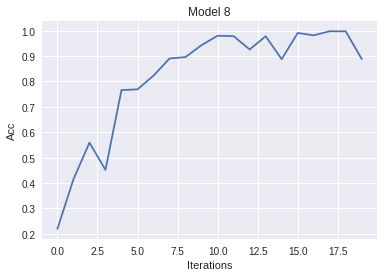

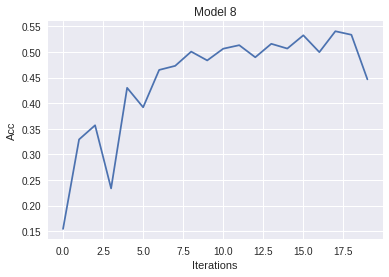

In [74]:
model8.cuda()
trainAcc, valAcc = verifyModel(model8, image_dataloader_train, 20)
plotGraphAcc(trainAcc, 'Model 8')
plotGraphAcc(valAcc, 'Model 8')

Starting epoch 1 / 8
t = 100, loss = 1.8968
t = 200, loss = 1.5294
t = 300, loss = 1.4787
Got 15947 / 23310 correct (68.41)
Got 3558 / 6690 correct (53.18)
Starting epoch 2 / 8
t = 100, loss = 1.2478
t = 200, loss = 1.1161
t = 300, loss = 0.9204
Got 18368 / 23310 correct (78.80)
Got 3996 / 6690 correct (59.73)
Starting epoch 3 / 8
t = 100, loss = 0.9697
t = 200, loss = 0.6547
t = 300, loss = 0.8181
Got 19649 / 23310 correct (84.29)
Got 4052 / 6690 correct (60.57)
Starting epoch 4 / 8
t = 100, loss = 0.9839
t = 200, loss = 0.6293
t = 300, loss = 0.5364
Got 20443 / 23310 correct (87.70)
Got 3962 / 6690 correct (59.22)
Starting epoch 5 / 8
t = 100, loss = 0.7341
t = 200, loss = 0.5850
t = 300, loss = 0.6384
Got 21045 / 23310 correct (90.28)
Got 4006 / 6690 correct (59.88)
Starting epoch 6 / 8
t = 100, loss = 0.5777
t = 200, loss = 0.6354
t = 300, loss = 0.7672
Got 21275 / 23310 correct (91.27)
Got 3986 / 6690 correct (59.58)
Starting epoch 7 / 8
t = 100, loss = 0.5841
t = 200, loss = 0.50

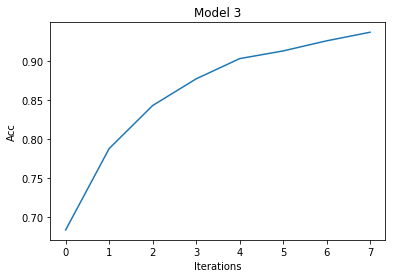

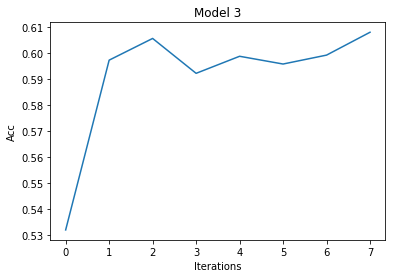

In [ ]:
trainAcc, valAcc = verifyModel(model3, image_dataloader_train, 8)
plotGraphAcc(trainAcc, 'Model 3')
plotGraphAcc(valAcc, 'Model 3')

In [ ]:
trainAcc, valAcc = verifyModel(model3, image_dataloader_val, 1)

Starting epoch 1 / 1
t = 100, loss = 0.4374
t = 200, loss = 0.7991
t = 300, loss = 1.3636
t = 400, loss = 0.7097
Got 19621 / 23310 correct (84.17)
Got 6136 / 6690 correct (91.72)


Starting epoch 1 / 8
t = 100, loss = 1.7317
t = 200, loss = 0.6700
t = 300, loss = 0.3594
t = 400, loss = 0.8623
t = 500, loss = 0.2376
t = 600, loss = 0.9365
t = 700, loss = 0.2187
Got 21596 / 23310 correct (92.65)
Got 3681 / 6690 correct (55.02)
Starting epoch 2 / 8
t = 100, loss = 0.1888
t = 200, loss = 0.0702
t = 300, loss = 0.1957
t = 400, loss = 0.0659
t = 500, loss = 0.1539
t = 600, loss = 0.0640
t = 700, loss = 0.1374
Got 20720 / 23310 correct (88.89)
Got 3376 / 6690 correct (50.46)
Starting epoch 3 / 8
t = 100, loss = 0.0206
t = 200, loss = 0.0056
t = 300, loss = 0.0804
t = 400, loss = 0.3428
t = 500, loss = 0.0369
t = 600, loss = 0.1317
t = 700, loss = 0.0818
Got 21725 / 23310 correct (93.20)
Got 3301 / 6690 correct (49.34)
Starting epoch 4 / 8
t = 100, loss = 0.0791
t = 200, loss = 0.0440
t = 300, loss = 0.1118
t = 400, loss = 0.2318
t = 500, loss = 0.0075
t = 600, loss = 0.1203
t = 700, loss = 0.2552
Got 21683 / 23310 correct (93.02)
Got 3528 / 6690 correct (52.74)
Starting

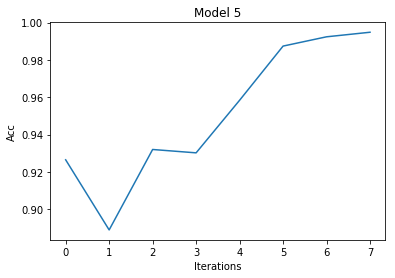

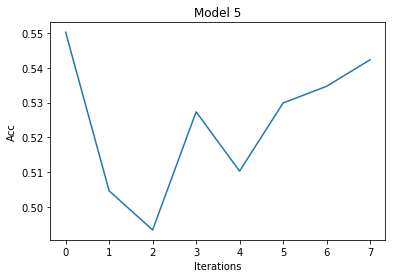

In [ ]:
trainAcc, valAcc = verifyModel(model5, image_dataloader_train, 8)
plotGraphAcc(trainAcc, 'Model 5')
plotGraphAcc(valAcc, 'Model 5')

Starting epoch 1 / 8
t = 100, loss = 1.7030
t = 200, loss = 1.2910
t = 300, loss = 1.0458
t = 400, loss = 0.7921
t = 500, loss = 0.8174
t = 600, loss = 0.7407
t = 700, loss = 0.4247
Got 17391 / 23310 correct (74.61)
Got 3436 / 6690 correct (51.36)
Starting epoch 2 / 8
t = 100, loss = 0.3315
t = 200, loss = 0.6120
t = 300, loss = 0.2292
t = 400, loss = 0.4764
t = 500, loss = 0.2294
t = 600, loss = 0.3710
t = 700, loss = 0.2627
Got 20409 / 23310 correct (87.55)
Got 3685 / 6690 correct (55.08)
Starting epoch 3 / 8
t = 100, loss = 0.2595
t = 200, loss = 0.6726
t = 300, loss = 0.1358
t = 400, loss = 0.4160
t = 500, loss = 0.2121
t = 600, loss = 0.1969
t = 700, loss = 0.1388
Got 21932 / 23310 correct (94.09)
Got 4122 / 6690 correct (61.61)
Starting epoch 4 / 8
t = 100, loss = 0.3356
t = 200, loss = 0.1573
t = 300, loss = 0.2613
t = 400, loss = 0.0612
t = 500, loss = 0.0872
t = 600, loss = 0.2891
t = 700, loss = 0.0402
Got 22218 / 23310 correct (95.32)
Got 4123 / 6690 correct (61.63)
Starting

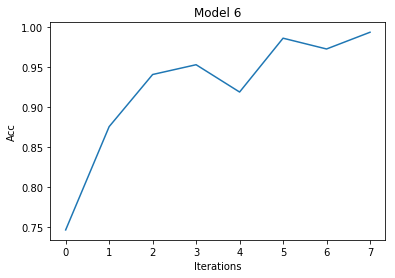

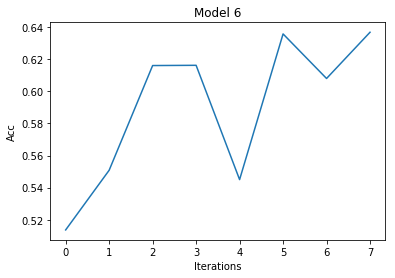

In [ ]:
trainAcc, valAcc = verifyModel(model6, image_dataloader_train, 8)
plotGraphAcc(trainAcc, 'Model 6')
plotGraphAcc(valAcc, 'Model 6')

Starting epoch 1 / 8
t = 100, loss = 1.7965
t = 200, loss = 1.6944
t = 300, loss = 1.4508
t = 400, loss = 1.0805
t = 500, loss = 0.9303
t = 600, loss = 1.0090
t = 700, loss = 0.9403
Got 14420 / 23310 correct (61.86)
Got 2720 / 6690 correct (40.66)
Starting epoch 2 / 8
t = 100, loss = 0.9003
t = 200, loss = 0.9024
t = 300, loss = 0.6498
t = 400, loss = 0.6528
t = 500, loss = 0.8079
t = 600, loss = 0.5840
t = 700, loss = 0.2919
Got 18711 / 23310 correct (80.27)
Got 3517 / 6690 correct (52.57)
Starting epoch 3 / 8
t = 100, loss = 0.3250
t = 200, loss = 0.5426
t = 300, loss = 0.5502
t = 400, loss = 0.2904
t = 500, loss = 0.3022
t = 600, loss = 0.3123
t = 700, loss = 0.2524
Got 21236 / 23310 correct (91.10)
Got 3528 / 6690 correct (52.74)
Starting epoch 4 / 8
t = 100, loss = 0.3209
t = 200, loss = 0.1784
t = 300, loss = 0.1983
t = 400, loss = 0.2606
t = 500, loss = 0.1965
t = 600, loss = 0.1178
t = 700, loss = 0.1907
Got 20395 / 23310 correct (87.49)
Got 3511 / 6690 correct (52.48)
Starting

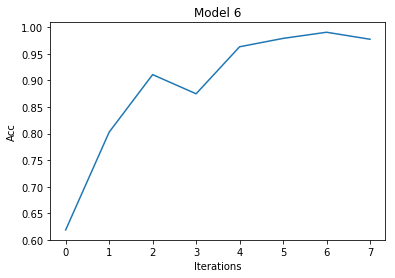

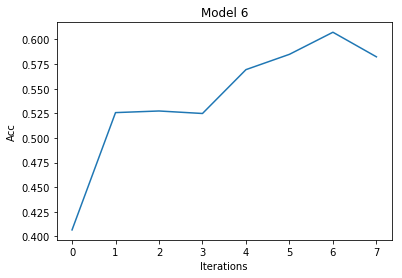

In [ ]:
# Model 6 with ReLU for FCL
trainAcc, valAcc = verifyModel(model6, image_dataloader_train, 8)
plotGraphAcc(trainAcc, 'Model 6')
plotGraphAcc(valAcc, 'Model 6')

Starting epoch 1 / 8
t = 100, loss = 1.7227
t = 200, loss = 1.2205
t = 300, loss = 1.1440
t = 400, loss = 1.2147
t = 500, loss = 1.0303
t = 600, loss = 0.7685
t = 700, loss = 0.6610
Got 16725 / 23310 correct (71.75)
Got 3001 / 6690 correct (44.86)
Starting epoch 2 / 8
t = 100, loss = 0.4642
t = 200, loss = 0.4615
t = 300, loss = 0.4227
t = 400, loss = 0.3402
t = 500, loss = 0.2545
t = 600, loss = 0.3099
t = 700, loss = 0.3258
Got 18419 / 23310 correct (79.02)
Got 2761 / 6690 correct (41.27)
Starting epoch 3 / 8
t = 100, loss = 0.2053
t = 200, loss = 0.2684
t = 300, loss = 0.3288
t = 400, loss = 0.3242
t = 500, loss = 0.2140
t = 600, loss = 0.2115
t = 700, loss = 1.3035
Got 22028 / 23310 correct (94.50)
Got 3820 / 6690 correct (57.10)
Starting epoch 4 / 8
t = 100, loss = 0.0789
t = 200, loss = 0.1333
t = 300, loss = 0.0400
t = 400, loss = 0.1659
t = 500, loss = 0.1562
t = 600, loss = 0.0533
t = 700, loss = 0.1240
Got 22346 / 23310 correct (95.86)
Got 3743 / 6690 correct (55.95)
Starting

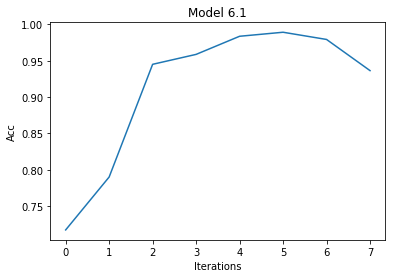

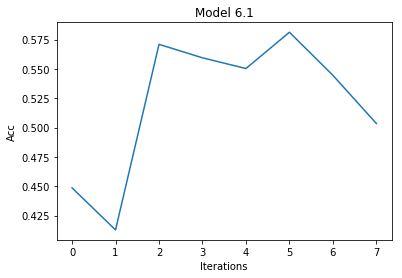

In [ ]:
trainAcc, valAcc = verifyModel(model61, image_dataloader_train, 8)
plotGraphAcc(trainAcc, 'Model 6.1')
plotGraphAcc(valAcc, 'Model 6.1')

Starting epoch 1 / 8
t = 100, loss = 1.5476
t = 200, loss = 1.3872
t = 300, loss = 1.0782
t = 400, loss = 0.8776
t = 500, loss = 0.6531
t = 600, loss = 0.6375
t = 700, loss = 0.4797
Got 18258 / 23310 correct (78.33)
Got 3373 / 6690 correct (50.42)
Starting epoch 2 / 8
t = 100, loss = 0.5402
t = 200, loss = 0.3380
t = 300, loss = 0.3842
t = 400, loss = 0.4307
t = 500, loss = 0.3989
t = 600, loss = 0.3109
t = 700, loss = 0.3133
Got 20567 / 23310 correct (88.23)
Got 3330 / 6690 correct (49.78)
Starting epoch 3 / 8
t = 100, loss = 0.3247
t = 200, loss = 0.1363
t = 300, loss = 0.1903
t = 400, loss = 0.0842
t = 500, loss = 0.0765
t = 600, loss = 0.1088
t = 700, loss = 0.1997
Got 21924 / 23310 correct (94.05)
Got 3783 / 6690 correct (56.55)
Starting epoch 4 / 8
t = 100, loss = 0.1123
t = 200, loss = 0.0802
t = 300, loss = 0.0382
t = 400, loss = 0.0814
t = 500, loss = 0.0188
t = 600, loss = 0.0611
t = 700, loss = 0.1128
Got 21186 / 23310 correct (90.89)
Got 3555 / 6690 correct (53.14)
Starting

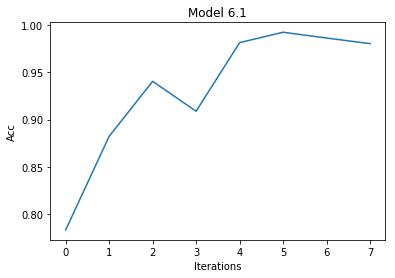

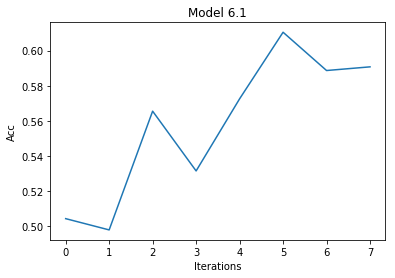

In [ ]:
trainAcc, valAcc = verifyModel(model61, image_dataloader_train, 8)
plotGraphAcc(trainAcc, 'Model 6.1')
plotGraphAcc(valAcc, 'Model 6.1')

Starting epoch 1 / 8
t = 100, loss = 1.9120
t = 200, loss = 1.1386
t = 300, loss = 0.9944
t = 400, loss = 0.7693
t = 500, loss = 0.6885
t = 600, loss = 0.6081
t = 700, loss = 0.5873
Got 19429 / 23310 correct (83.35)
Got 3702 / 6690 correct (55.34)
Starting epoch 2 / 8
t = 100, loss = 0.6705
t = 200, loss = 0.3562
t = 300, loss = 0.5470
t = 400, loss = 0.2781
t = 500, loss = 0.3409
t = 600, loss = 0.3216
t = 700, loss = 0.3153
Got 21815 / 23310 correct (93.59)
Got 3863 / 6690 correct (57.74)
Starting epoch 3 / 8
t = 100, loss = 0.2851
t = 200, loss = 0.2381
t = 300, loss = 0.2096
t = 400, loss = 0.1256
t = 500, loss = 0.1306
t = 600, loss = 0.3011
t = 700, loss = 0.1492
Got 22503 / 23310 correct (96.54)
Got 4130 / 6690 correct (61.73)
Starting epoch 4 / 8
t = 100, loss = 0.0784
t = 200, loss = 0.1821
t = 300, loss = 0.1180
t = 400, loss = 0.3493
t = 500, loss = 0.0675
t = 600, loss = 0.1586
t = 700, loss = 0.0277
Got 22668 / 23310 correct (97.25)
Got 3853 / 6690 correct (57.59)
Starting

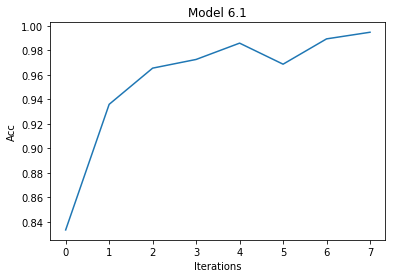

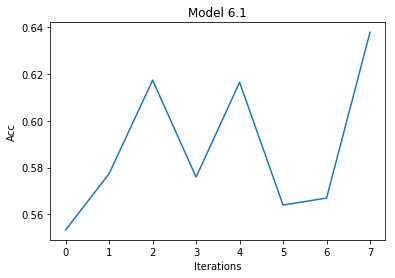

In [ ]:
# With Dropout and Adam
trainAcc, valAcc = verifyModel(model61, image_dataloader_train, 8)
plotGraphAcc(trainAcc, 'Model 6.1')
plotGraphAcc(valAcc, 'Model 6.1')

Starting epoch 1 / 8
t = 100, loss = 2.1010
t = 200, loss = 2.2125
t = 300, loss = 1.6066
t = 400, loss = 1.4107
t = 500, loss = 1.3005
t = 600, loss = 1.4959
t = 700, loss = 1.5079
Got 11951 / 23310 correct (51.27)
Got 1940 / 6690 correct (29.00)
Starting epoch 2 / 8
t = 100, loss = 1.1320
t = 200, loss = 1.0920
t = 300, loss = 1.3414
t = 400, loss = 0.7298
t = 500, loss = 0.7747
t = 600, loss = 0.9305
t = 700, loss = 0.9315
Got 14987 / 23310 correct (64.29)
Got 2677 / 6690 correct (40.01)
Starting epoch 3 / 8
t = 100, loss = 0.8075
t = 200, loss = 0.7142
t = 300, loss = 0.7489
t = 400, loss = 0.8170
t = 500, loss = 0.6388
t = 600, loss = 0.8911
t = 700, loss = 0.4399
Got 17842 / 23310 correct (76.54)
Got 2838 / 6690 correct (42.42)
Starting epoch 4 / 8
t = 100, loss = 0.5785
t = 200, loss = 0.6014
t = 300, loss = 0.8176
t = 400, loss = 0.5516
t = 500, loss = 0.3390
t = 600, loss = 0.5591
t = 700, loss = 0.3432
Got 16801 / 23310 correct (72.08)
Got 2683 / 6690 correct (40.10)
Starting

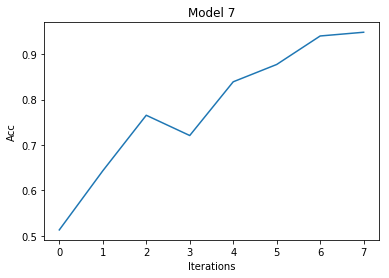

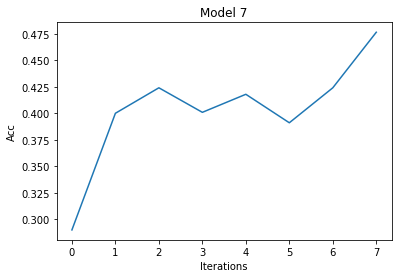

In [ ]:
trainAcc, valAcc = verifyModel(model7, image_dataloader_train, 8)
plotGraphAcc(trainAcc, 'Model 7')
plotGraphAcc(valAcc, 'Model 7')

Starting epoch 1 / 3
t = 100, loss = 0.1042
t = 200, loss = 0.2947
t = 300, loss = 0.2017
t = 400, loss = 0.1192
t = 500, loss = 0.0902
t = 600, loss = 0.1401
t = 700, loss = 0.0590
Got 19618 / 23310 correct (84.16)
Got 2475 / 6690 correct (37.00)
Starting epoch 2 / 3
t = 100, loss = 0.1437
t = 200, loss = 0.0541
t = 300, loss = 0.2155
t = 400, loss = 0.0779
t = 500, loss = 0.2729
t = 600, loss = 0.0797
t = 700, loss = 0.3194
Got 22645 / 23310 correct (97.15)
Got 3003 / 6690 correct (44.89)
Starting epoch 3 / 3
t = 100, loss = 0.1570
t = 200, loss = 0.1555
t = 300, loss = 0.0563
t = 400, loss = 0.0836
t = 500, loss = 0.0447
t = 600, loss = 0.1775
t = 700, loss = 0.0706
Got 22703 / 23310 correct (97.40)
Got 3201 / 6690 correct (47.85)


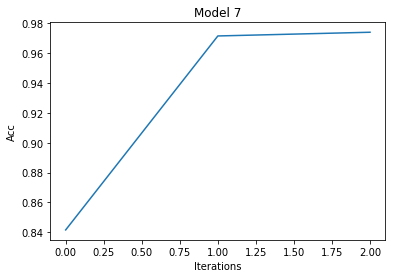

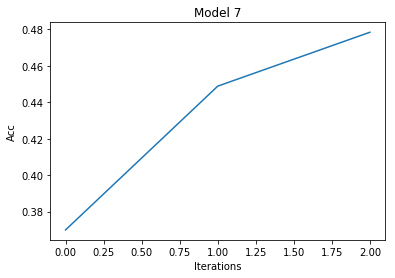

In [ ]:
trainAcc, valAcc = verifyModel(model7, image_dataloader_train, 3)
plotGraphAcc(trainAcc, 'Model 7')
plotGraphAcc(valAcc, 'Model 7')

Starting epoch 1 / 10
t = 100, loss = 2.0585
t = 200, loss = 1.9812
t = 300, loss = 1.9412
Got 7692 / 23310 correct (33.00)
Got 1434 / 6690 correct (21.43)
Starting epoch 2 / 10
t = 100, loss = 1.9870
t = 200, loss = 1.6708
t = 300, loss = 1.4870
Got 10966 / 23310 correct (47.04)
Got 1963 / 6690 correct (29.34)
Starting epoch 3 / 10
t = 100, loss = 1.7133
t = 200, loss = 1.5080
t = 300, loss = 1.3763
Got 15505 / 23310 correct (66.52)
Got 2380 / 6690 correct (35.58)
Starting epoch 4 / 10
t = 100, loss = 1.3079
t = 200, loss = 1.1970
t = 300, loss = 1.2106
Got 16200 / 23310 correct (69.50)
Got 2470 / 6690 correct (36.92)
Starting epoch 5 / 10
t = 100, loss = 0.9444
t = 200, loss = 1.1092
t = 300, loss = 0.8322
Got 16901 / 23310 correct (72.51)
Got 2560 / 6690 correct (38.27)
Starting epoch 6 / 10
t = 100, loss = 1.0440
t = 200, loss = 0.5331
t = 300, loss = 0.8137
Got 17802 / 23310 correct (76.37)
Got 2548 / 6690 correct (38.09)
Starting epoch 7 / 10
t = 100, loss = 0.8008
t = 200, loss 

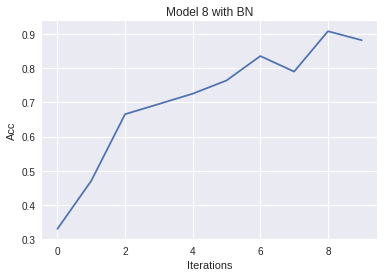

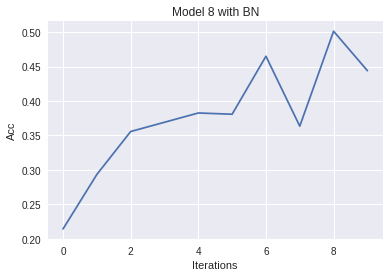

In [92]:
trainAcc, valAcc = verifyModel(model8, image_dataloader_train, 10)
plotGraphAcc(trainAcc, 'Model 8 with BN')
plotGraphAcc(valAcc, 'Model 8 with BN')

In [ ]:
model5.load_state_dict(torch.load('2dmodels/2dModel_8.pkl'))

### Don't forget the validation set!

And note that you can use the check_accuracy function to evaluate on the validation set, by passing **image_dataloader_val** as the second argument to check_accuracy. The accuracy on validation set is arround 40-50%.

In [ ]:
check_accuracy(model5, image_dataloader_val)#check accuracy on the validation set

Got 3917 / 6690 correct (58.55)


0.5855007473841555

##### Train a better  model for action recognition!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition **validation** set. You can use the check_accuracy and train functions from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 55% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. 



In [ ]:
###########3rd To Do (16 points, must submit the results to Kaggle) ##############
# Train your model here, and make sure the output of this cell is the accuracy of your best model on the 
# train, val, and test sets. Here's some code to get you started. The output of this cell should be the training
# and validation accuracy on your best model (measured by validation accuracy).

model = model_normed
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=8) 
check_accuracy(model, image_dataloader_val)

Starting epoch 1 / 8
t = 100, loss = 1.1881
t = 200, loss = 1.2007
t = 300, loss = 1.0545
t = 400, loss = 1.3181
t = 500, loss = 0.7433
t = 600, loss = 0.6169
t = 700, loss = 0.6584
Starting epoch 2 / 8
t = 100, loss = 0.6454
t = 200, loss = 0.6708
t = 300, loss = 0.5458
t = 400, loss = 0.4704
t = 500, loss = 0.4655
t = 600, loss = 0.3875
t = 700, loss = 0.3964
Starting epoch 3 / 8
t = 100, loss = 0.3589
t = 200, loss = 0.4541
t = 300, loss = 0.4856
t = 400, loss = 0.3909
t = 500, loss = 0.3532
t = 600, loss = 0.2403
t = 700, loss = 0.3718
Starting epoch 4 / 8
t = 100, loss = 0.2418
t = 200, loss = 0.2650
t = 300, loss = 0.1580
t = 400, loss = 0.2937
t = 500, loss = 0.2462
t = 600, loss = 0.2673
t = 700, loss = 0.2020
Starting epoch 5 / 8
t = 100, loss = 0.1625
t = 200, loss = 0.2188
t = 300, loss = 0.3638
t = 400, loss = 0.4827
t = 500, loss = 0.1180
t = 600, loss = 0.3159
t = 700, loss = 0.3869
Starting epoch 6 / 8
t = 100, loss = 0.2619
t = 200, loss = 0.0672
t = 300, loss = 0.1582


In [ ]:
check_accuracy(model5, image_dataloader_train)

Got 6504 / 23310 correct (27.90)


0.279021879021879

In [ ]:
trainAcc, valAcc = verifyModel(model5, image_dataloader_train, 1)

Starting epoch 1 / 1
t = 100, loss = 0.0122
t = 200, loss = 0.0031
t = 300, loss = 0.0110
t = 400, loss = 0.0031
t = 500, loss = 0.0117
t = 600, loss = 0.0353
t = 700, loss = 0.0042
Got 23229 / 23310 correct (99.65)
Got 4752 / 6690 correct (71.03)
Got 23229 / 23310 correct (99.65)


In [ ]:
trainAcc, valAcc = verifyModel(model5, image_dataloader_val, 1)

Starting epoch 1 / 1
t = 100, loss = 0.5491
t = 200, loss = 0.0401
t = 300, loss = 0.0492
t = 400, loss = 0.0209
Got 20180 / 23310 correct (86.57)
Got 6639 / 6690 correct (99.24)
Got 20180 / 23310 correct (86.57)


In [ ]:
trainAcc, valAcc = verifyModel(model6, image_dataloader_val, 1)

Starting epoch 1 / 1
t = 100, loss = 0.0311
t = 200, loss = 0.1651
t = 300, loss = 0.0743
t = 400, loss = 0.0371
Got 18909 / 23310 correct (81.12)
Got 6322 / 6690 correct (94.50)
Got 18909 / 23310 correct (81.12)


### Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Tell us here!
###########4th To Do (4 points) ##############
1. Implemented mentioned CNN
2. Modified architecture by adding more CN layers, FC Layers
2. Tried around 9-10 variations by adding Batch Normalization, DropOut, FC layers, Different Kernel Size
3. Architecture with Batch Normalization tend to perform better
4. Model 3 - Train

<img src="Plots/Model3_Train.png">

Model 3 - Validation
<img src="Plots/Model3_Val.png">
5. Model 6 - Batch Normalization

Train

<img src="Plots/Model6_Train.png">

Validation

<img src="Plots/Model6_Val.png">

### Testing the model and submit on Kaggle
Testing the model on the testing set and save the results as a .csv file. 
Please submitted the results.csv file generated by predict_on_test() to Kaggle(https://www.kaggle.com/c/cse512springhw3) to see how well your network performs on the test set. 
#######5th To Do (submit the result to Kaggle,the highest 3 entries get extra 10 points )###############

Kaggle score: 61.25382

In [ ]:
def predict_on_test(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'])
        scores = model(x_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
    return count
    
count=predict_on_test(model61, image_dataloader_test)
print(count)

9810


### GPU! (This part is optional, 0 points)

If you have access to GPU, you can make the code run on GPU, it would be much faster. 

Now, we're going to switch the dtype of the model and our data to the GPU-friendly tensors, and see what happens... everything is the same, except we are casting our model and input tensors as this new dtype instead of the old one.

If this returns false, or otherwise fails in a not-graceful way (i.e., with some error message), you may not have an NVIDIA GPU available on your machine. 

In [ ]:
# Verify that CUDA is properly configured and you have a GPU available

torch.cuda.is_available()

In [ ]:
import copy
gpu_dtype = torch.cuda.FloatTensor

fixed_model_gpu = copy.deepcopy(fixed_model_base)#.type(gpu_dtype)
fixed_model_gpu.cuda()
x_gpu = torch.randn(4, 3, 64, 64).cuda()#.type(gpu_dtype)
x_var_gpu = Variable(x_gpu)#type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([4, 10]))


Run the following cell to evaluate the performance of the forward pass running on the CPU:

In [ ]:
%%timeit 
ans = fixed_model(x_var)

... and now the GPU:

In [ ]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use the GPU datatype for your model and your tensors: as a reminder that is *torch.cuda.FloatTensor* (in our notebook here as *gpu_dtype*)

Let's make the loss function and training variables to GPU friendly format by '.cuda()'

In [ ]:
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.RMSprop(fixed_model_gpu.parameters(), lr=1e-4)

In [ ]:
def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['image'].cuda())
            y_var = Variable(sample['Label'].cuda().long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'].cuda())
        y_var = sample['Label'].cuda()
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

Run on GPU!

In [ ]:
torch.cuda.random.manual_seed(12345)

fixed_model_gpu.apply(reset) 
fixed_model_gpu.train() 
train(fixed_model_gpu, loss_fn, optimizer,image_dataloader_train, num_epochs=1) 
check_accuracy(fixed_model_gpu, image_dataloader_train)# check accuracy on the training set


### 3D Convolution on video clips (25 points+10 extra points)
3D convolution is for videos, it has one more dimension than 2d convolution. You can find the document for 3D convolution here http://pytorch.org/docs/master/nn.html#torch.nn.Conv3dIn. In our dataset, each clip is a video of 3 frames. Lets classify the each clip rather than each image using 3D convolution.
We offer the data loader, the train_3d and check_accuracy

In [75]:
class ActionClipDataset(Dataset):
    """Action Landmarks dataset."""

    def __init__(self,  root_dir,labels=[], transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
        folder=idx+1
        folder=format(folder,'05d')
        clip=[]
        if len(self.labels)!=0:
            Label=self.labels[idx][0]-1
        for i in range(3):
            imidx=i+1
            imgname=str(imidx)+'.jpg'
            img_path = os.path.join(self.root_dir,
                                    folder,imgname)
            image = Image.open(img_path)
            image=np.array(image)
            clip.append(image)
        if self.transform:
            clip=np.asarray(clip)
            clip=np.transpose(clip, (0,3,1,2))
            clip = torch.from_numpy(np.asarray(clip))
        if len(self.labels)!=0:
            sample={'clip':clip,'Label':Label,'folder':folder}
        else:
            sample={'clip':clip,'folder':folder}
        return sample

clip_dataset=ActionClipDataset(root_dir='./data/trainClips/',\
                               labels=label_train,transform=T.ToTensor())#/home/tqvinh/Study/CSE512/cse512-s18/hw2data/trainClips/
for i in range(10):
    sample=clip_dataset[i]
    print(sample['clip'].shape)
    print(sample['Label'])
    print(sample['folder'])

torch.Size([3, 3, 64, 64])
0.0
00001
torch.Size([3, 3, 64, 64])
0.0
00002
torch.Size([3, 3, 64, 64])
0.0
00003
torch.Size([3, 3, 64, 64])
0.0
00004
torch.Size([3, 3, 64, 64])
0.0
00005
torch.Size([3, 3, 64, 64])
0.0
00006
torch.Size([3, 3, 64, 64])
0.0
00007
torch.Size([3, 3, 64, 64])
0.0
00008
torch.Size([3, 3, 64, 64])
0.0
00009
torch.Size([3, 3, 64, 64])
0.0
00010


In [76]:
clip_dataloader = DataLoader(clip_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


for i,sample in enumerate(clip_dataloader):
    print(i,sample['clip'].shape,sample['folder'],sample['Label'])
    if i>20: 
        break

(0, torch.Size([4, 3, 3, 64, 64]), ['03064', '01464', '05567', '02832'], 
 3
 1
 6
 3
[torch.DoubleTensor of size 4]
)
(1, torch.Size([4, 3, 3, 64, 64]), ['07649', '07661', '03043', '05800'], 
 9
 9
 3
 7
[torch.DoubleTensor of size 4]
)
(2, torch.Size([4, 3, 3, 64, 64]), ['06834', '00617', '06078', '03540'], 
 8
 0
 7
 4
[torch.DoubleTensor of size 4]
)
(3, torch.Size([4, 3, 3, 64, 64]), ['00137', '04585', '00714', '07564'], 
 0
 5
 0
 9
[torch.DoubleTensor of size 4]
)
(4, torch.Size([4, 3, 3, 64, 64]), ['02147', '07628', '07105', '00942'], 
 2
 9
 8
 1
[torch.DoubleTensor of size 4]
)
(5, torch.Size([4, 3, 3, 64, 64]), ['00040', '03168', '06547', '07465'], 
 0
 3
 8
 9
[torch.DoubleTensor of size 4]
)
(6, torch.Size([4, 3, 3, 64, 64]), ['02501', '03949', '00304', '00574'], 
 2
 4
 0
 0
[torch.DoubleTensor of size 4]
)
(7, torch.Size([4, 3, 3, 64, 64]), ['00998', '00925', '02881', '04820'], 
 1
 1
 3
 5
[torch.DoubleTensor of size 4]
)
(8, torch.Size([4, 3, 3, 64, 64]), ['00539', '02

In [ ]:
clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=T.ToTensor())

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=16,
                        shuffle=True, num_workers=4)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=T.ToTensor())

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=16,
                        shuffle=True, num_workers=4)
clip_dataset_test=ActionClipDataset(root_dir='./data/testClips/',labels=[],transform=T.ToTensor())

clip_dataloader_test = DataLoader(clip_dataset_test, batch_size=16,
                        shuffle=False, num_workers=4)

Write the Flatten for 3d covolution feature maps.

In [ ]:
class Flatten3d(nn.Module):
    def forward(self, x):
        ###############6th To Do (5 points)###################
        N, C, D, H, W = x.size() # read in N, C, D, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image        

Design a network using 3D convolution on videos for video classification.

In [ ]:
fixed_model_3d = nn.Sequential( # You fill this in!
    ###############7th To Do (16 points)#########################
        nn.Conv3d(3, 8, padding = 4, kernel_size = 3, stride = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool3d(2, stride = 2),
        nn.Conv3d(8, 16, kernel_size = 3, stride = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool3d(2, stride = 2),
        Flatten3d(),
        nn.ReLU(inplace = True),
        nn.Linear(4096, 10) 
)

fixed_model_3d = fixed_model_3d.type(dtype)
x = torch.randn(32, 3, 3, 64, 64).type(dtype)
x_var = Variable(x).type(dtype) # Construct a PyTorch Variable out of your input data
ans = fixed_model_3d(x_var) 
np.array_equal(np.array(ans.size()), np.array([32, 10]))


True

In [83]:
# Deep Model Video
modelv_base = nn.Sequential( 
            nn.Conv3d(3, 8, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool3d(2, stride = 2),
            nn.Dropout3d(p=0.2), 
            nn.Conv3d(8, 16, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool3d(2, stride = 2),
            nn.Dropout3d(p=0.2), 
            nn.Conv3d(16, 32, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool3d(2, stride = 2),
            nn.Dropout3d(p=0.2), 
            nn.Conv3d(32, 64, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool3d(2, stride = 2),
            nn.Dropout3d(p=0.2), 
            nn.Conv3d(64, 128, padding = 4, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool3d(2, stride = 2),
            nn.Dropout3d(p=0.2), 
            nn.Conv3d(128, 256,padding = 2, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool3d(2, stride = 2),
            nn.Dropout3d(p=0.2), 
            nn.Conv3d(256, 512, padding = 2, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool3d(2, stride = 2),
            nn.Dropout3d(p=0.2), 
            nn.Conv3d(512, 1024, padding = 2, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool3d(2, stride = 2),
            Flatten3d(),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2), 
            nn.Linear(8192, 2048),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2), 
            nn.Linear(2048, 1024),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2), 
            nn.Linear(1024, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2), 
            nn.Linear(512, 10)
            )
modelv = modelv_base.type(dtype)
modelv.cuda()

Sequential(
  (0): Conv3d (3, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4))
  (1): ReLU(inplace)
  (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout3d(p=0.2)
  (4): Conv3d (8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4))
  (5): ReLU(inplace)
  (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout3d(p=0.2)
  (8): Conv3d (16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4))
  (9): ReLU(inplace)
  (10): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout3d(p=0.2)
  (12): Conv3d (32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4))
  (13): ReLU(inplace)
  (14): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout3d(p=0.2)
  (16): Conv3d (64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4))
  (17): ReLU(inplace)
  (18): MaxPool3d(kernel_size=2, strid

### Describe what you did (4 points)

In the cell below you should write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

8th To Do
Tell us here:
1. Implemented basic 3D CNN version of fixed_model from 2D CNN used in first part
2. Extended Model 8 with Deep CNN going to 1024 channels
3. Using DropOuts, MaxPool and BatchNormalization

In [ ]:
def train_3d(model, loss_fn, optimizer,dataloader,num_epochs = 1):
    trainAcc = []
    valAcc = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = var(sample['clip'].type(dtype))
            y_var = var(sample['Label'].type(dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        trainAcc.append(check_accuracy_3d(model, clip_dataloader_train))
        valAcc.append(check_accuracy_3d(model, clip_dataloader_val))
    return trainAcc, valAcc

def check_accuracy_3d(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = var(sample['clip'].type(dtype))
        y_var = sample['Label'].type(dtype)
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:
torch.cuda.random.manual_seed(12345)
fixed_model_3d.apply(reset) 
fixed_model_3d.train() 
train_3d(fixed_model_3d, loss_fn, optimizer,clip_dataloader_train, num_epochs=10) 
fixed_model_3d.eval() 
check_accuracy_3d(fixed_model_3d, clip_dataloader_val)

Starting epoch 1 / 10
t = 100, loss = 1.8423
t = 200, loss = 1.1793
t = 300, loss = 1.0392
t = 400, loss = 0.6315
Starting epoch 2 / 10
t = 100, loss = 0.1108
t = 200, loss = 0.0366
t = 300, loss = 0.3611
t = 400, loss = 0.0313
Starting epoch 3 / 10
t = 100, loss = 0.0724
t = 200, loss = 0.0925
t = 300, loss = 0.0870
t = 400, loss = 0.0115
Starting epoch 4 / 10
t = 100, loss = 0.0323
t = 200, loss = 0.0209
t = 300, loss = 0.0075
t = 400, loss = 0.0109
Starting epoch 5 / 10
t = 100, loss = 0.0442
t = 200, loss = 0.0916
t = 300, loss = 0.0540
t = 400, loss = 0.0299
Starting epoch 6 / 10
t = 100, loss = 0.0549
t = 200, loss = 0.2313
t = 300, loss = 0.0024
t = 400, loss = 0.0390
Starting epoch 7 / 10
t = 100, loss = 0.0150
t = 200, loss = 0.0475
t = 300, loss = 0.0001
t = 400, loss = 0.0053
Starting epoch 8 / 10
t = 100, loss = 0.0006
t = 200, loss = 0.0108
t = 300, loss = 0.0035
t = 400, loss = 0.0122
Starting epoch 9 / 10
t = 100, loss = 0.0044
t = 200, loss = 0.0002
t = 300, loss = 0.00

Starting epoch 1 / 5
t = 100, loss = 0.9966
t = 200, loss = 0.9597
t = 300, loss = 0.8128
t = 400, loss = 1.0918
Got 6478 / 7770 correct (83.37)
Got 1170 / 2230 correct (52.47)
Starting epoch 2 / 5
t = 100, loss = 0.6380
t = 200, loss = 0.9579
t = 300, loss = 0.4415
t = 400, loss = 0.6365
Got 6837 / 7770 correct (87.99)
Got 1213 / 2230 correct (54.39)
Starting epoch 3 / 5
t = 100, loss = 0.4954
t = 200, loss = 0.6276
t = 300, loss = 1.0205
t = 400, loss = 0.8404
Got 6683 / 7770 correct (86.01)
Got 1100 / 2230 correct (49.33)
Starting epoch 4 / 5
t = 100, loss = 0.3458
t = 200, loss = 0.2708
t = 300, loss = 0.2445
t = 400, loss = 0.1404
Got 7105 / 7770 correct (91.44)
Got 1148 / 2230 correct (51.48)
Starting epoch 5 / 5
t = 100, loss = 0.3762
t = 200, loss = 1.0454
t = 300, loss = 0.7594
t = 400, loss = 0.0797
Got 7305 / 7770 correct (94.02)
Got 1243 / 2230 correct (55.74)


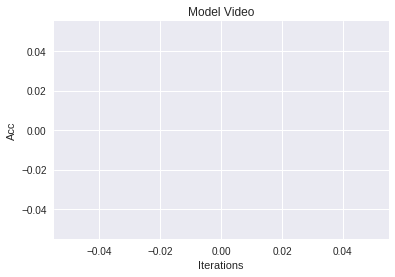

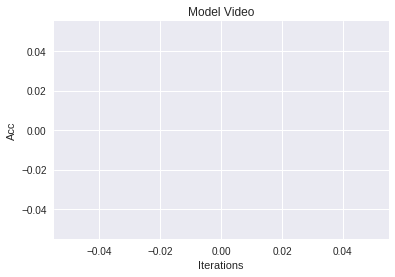

In [98]:
modelv.cuda()
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.RMSprop(modelv.parameters(), lr=1e-4)
trainAcc, valAcc = train_3d(modelv, loss_fn, optimizer,clip_dataloader_train, num_epochs=5) 
plotGraphAcc(trainAcc, 'Model Video')
plotGraphAcc(valAcc, 'Model Video')

Test your 3d convolution model on the validation set. You don't need to submit the result of this part to kaggle.  

Test your model on the test set, predict_on_test_3d() will generate a file named 'results_3d.csv'. Please submit the csv file to kaggle https://www.kaggle.com/c/cse512springhw3video
The highest 3 entries get extra 10 points.


In [ ]:
def predict_on_test_3d(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results_3d.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for t, sample in enumerate(loader):
        x_var = Variable(sample['clip'].type(dtype))
        scores = model(x_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
    return count
    
count=predict_on_test_3d(fixed_model_3d, clip_dataloader_test)
print(count)

3270
